In [89]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [90]:
store_sales = pd.read_csv('train.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Check for Null Values


In [91]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Dropping Store and item columns

In [92]:
store_sales = store_sales.drop(['store','item'],axis=1)

In [93]:
store_sales

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
...,...,...
912995,2017-12-27,63
912996,2017-12-28,59
912997,2017-12-29,74
912998,2017-12-30,62


Standardizing Data

In [94]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [95]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Converting date to a month period, and the adding the # of items for each month


In [96]:
store_sales['date'] = store_sales['date'].dt.to_period("M") #'m' means month, not changed in the DF only for this cell
monthly_sales = store_sales.groupby('date').sum().reset_index() #reorganizes the list after changing things

Convert results into timestamp datatype

In [97]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [98]:
monthly_sales

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualization

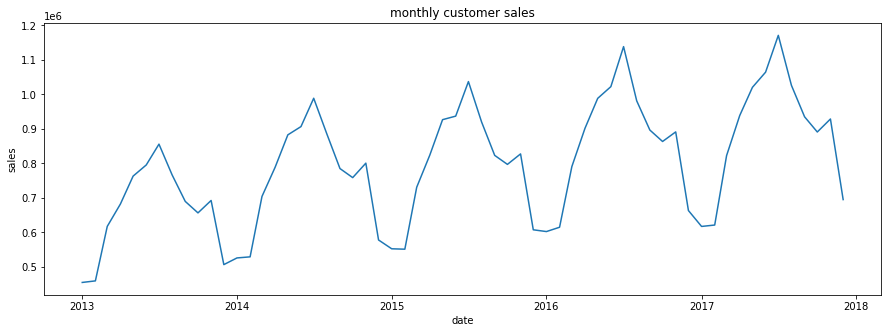

In [99]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('date')
plt.ylabel("sales")
plt.title("monthly customer sales")
plt.show()

Call the diference on sales to make the sales data stationary

In [100]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


Dropping off sales and date

In [101]:
supervised_data = monthly_sales.drop(['date', 'sales'],axis=1)

preparing the supervized data

In [102]:
for i in range(1,13):
    col_name = 'month' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


split the data into train and test

In [103]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print('train data shape: ', train_data.shape)
print('test data shape: ', test_data.shape)

train data shape:  (35, 13)
test data shape:  (12, 13)


In [104]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [105]:
x_train,y_train = train_data[:,1:], train_data[:,0:1]
x_test,y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print(' x_train shape ', x_train.shape)
print(' y_train shape ', y_train.shape)
print(' x_test shape ', x_test.shape)
print(' y_test shape ', y_test.shape)

 x_train shape  (35, 12)
 y_train shape  (35,)
 x_test shape  (12, 12)
 y_test shape  (12,)


Make prediction DF to merge the predicted sales prices of all trained algs

In [106]:
sales_date = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_date)

C:\Users\jvict\AppData\Local\Temp\ipykernel_10100\2549919408.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sales_date = monthly_sales['date'][-12:].reset_index(drop=True)


In [107]:
act_sales = monthly_sales['sales'][-13:].to_list()

C:\Users\jvict\AppData\Local\Temp\ipykernel_10100\2173393283.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  act_sales = monthly_sales['sales'][-13:].to_list()


In [108]:
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Create the linear regression model, and predicted output

In [109]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [110]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis = 1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [111]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name= "Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

In [112]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])


print("Linear Regression MSE ", lr_mse)
print("Linear Regression MAE ", lr_mae)
print("Linear Regression R2 ", lr_r2)

Linear Regression MSE  16221.272385416896
Linear Regression MAE  12433.184266490784
Linear Regression R2  0.9906152516380968


C:\Users\jvict\AppData\Local\Temp\ipykernel_10100\1217758384.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
C:\Users\jvict\AppData\Local\Temp\ipykernel_10100\1217758384.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
C:\Users\jvict\AppData\Local\Temp\ipykernel_10100\1217758384.py:3:

Visualizing the predictions vs the actual values

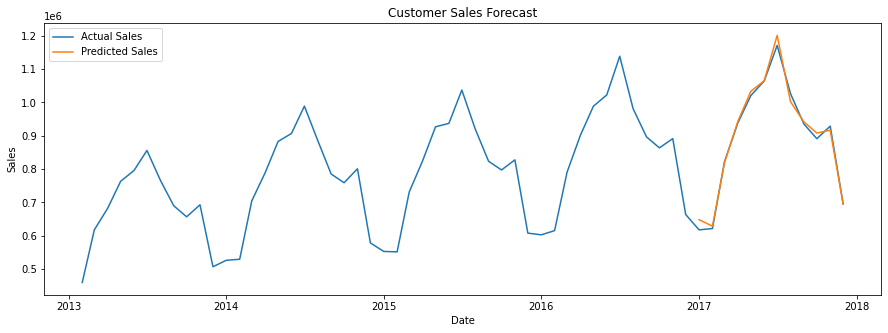

In [119]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales']) #actual sales graph
plt.plot(predict_df['date'], predict_df['Linear Prediction']) #predicted sales
plt.title('Customer Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()